# Project 08. Markor Chain Monte Carlo Simulation - Data Analysis 

## 1. Defining Goal 


Our sales department is interested in a summary of the collected data. Please generate a report including numbers and diagrams. Note that your audience are not data scientists, so take care to prepare insights that are as clear as possible. We are interested in the following:

1. Calculate the total number of customers in each section

2. Calculate the total number of customers in each section over time

3. Display the number of customers at checkout over time

4. Calculate the time each customer spent in the market

5. Calculate the total number of customers in the supermarket over time

6. Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).


## 2. Importing Libraries

In [209]:
import os
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

## 3. Data Wrangling

### 3.1. Loading Data

In [210]:
df_list = []

for file in os.listdir('data/'):
    if file.endswith(".csv"):
        df = pd.read_csv(f'data/{file}', parse_dates=True, sep=';', index_col='timestamp')
        df_list.append(df)

df = pd.concat(df_list)

In [211]:
df.sort_values(by='timestamp', inplace=True)
df.head()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices


### 3.2. Extracting datetime features

In [212]:
# add columns with extracted datetime features
df["time"] = df.index.time
df["day"] = df.index.dayofweek
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df.head()

,customer_no,location,time,day,date,hour,minute
timestamp,,,,,,,
2019-09-02 07:03:00,1,dairy,07:03:00,0,2019-09-02,7,3
2019-09-02 07:03:00,2,dairy,07:03:00,0,2019-09-02,7,3
2019-09-02 07:04:00,3,dairy,07:04:00,0,2019-09-02,7,4
2019-09-02 07:04:00,4,dairy,07:04:00,0,2019-09-02,7,4
2019-09-02 07:04:00,5,spices,07:04:00,0,2019-09-02,7,4


### 3.3. Adding missing 'checkout' values

In [213]:
# at first, creating unique customer ID from day and customer_no  
df['customer_no'] = df['day'].astype(str) + '_' + df['customer_no'].astype(str)

In [214]:
df.head(1)

,customer_no,location,time,day,date,hour,minute
timestamp,,,,,,,
2019-09-02 07:03:00,0_1,dairy,07:03:00,0,2019-09-02,7,3


In [215]:
# supermarket closing time, we need for the function calculating the customers without checkout location 
closing_time = df.index.max().time()
print(closing_time)

21:50:00


In [216]:
df.columns

Index(['customer_no', 'location', 'time', 'day', 'date', 'hour', 'minute'], dtype='object')

In [217]:
def add_missing_customer_checkout(df):
    
    customer_ids = df['customer_no'].unique()
    for id in customer_ids:
        customer_df = df[df['customer_no']==id]
        
        if 'checkout' in customer_df['location'].values:
            pass
        else:
            checkout_dict = {'customer_no': id, 'location':'checkout', 'time': closing_time, 'day':np.nan, "date": np.nan, 'hour': 21, 'minute': 50}
            print(id)
            df = df.append(checkout_dict, ignore_index=True)
    
    return df

In [218]:
df = add_missing_customer_checkout(df)

0_1430
0_1433
0_1437
0_1440
0_1439
0_1441
0_1443
0_1445
0_1446
0_1447
1_1411
1_1422
2_1520
2_1527
2_1529
2_1528
2_1530
3_1527
3_1532
3_1533
4_1494
4_1496
4_1500
4_1503
4_1505
4_1506
4_1510
4_1509


In [219]:
# checking the NaN values 
df.isna().sum()

customer_no     0
location        0
time            0
day            28
date           28
hour            0
minute          0
dtype: int64

In [220]:
# df[df['customer_no'].isna() == True]

In [221]:
# fill missing values in each column using forward fill method

df = df.sort_values(by=['customer_no', 'time']).fillna(method='ffill')
df.head(10)

,customer_no,location,time,day,date,hour,minute
0,0_1,dairy,07:03:00,0.0,2019-09-02,7,3
8,0_1,checkout,07:05:00,0.0,2019-09-02,7,5
16,0_10,fruit,07:06:00,0.0,2019-09-02,7,6
25,0_10,checkout,07:08:00,0.0,2019-09-02,7,8
306,0_100,drinks,07:56:00,0.0,2019-09-02,7,56
333,0_100,checkout,08:03:00,0.0,2019-09-02,8,3
3400,0_1000,dairy,17:44:00,0.0,2019-09-02,17,44
3438,0_1000,drinks,17:50:00,0.0,2019-09-02,17,50
3443,0_1000,checkout,17:51:00,0.0,2019-09-02,17,51
3402,0_1001,fruit,17:45:00,0.0,2019-09-02,17,45


In [222]:
df.isna().sum()

customer_no    0
location       0
time           0
day            0
date           0
hour           0
minute         0
dtype: int64

In [223]:
# checking wether "checkout" value has been added to random customer  
df[df['customer_no']=='4_1503']

,customer_no,location,time,day,date,hour,minute
24858,4_1503,dairy,21:47:00,4.0,2019-09-06,21,47
24867,4_1503,drinks,21:49:00,4.0,2019-09-06,21,49
24900,4_1503,checkout,21:50:00,4.0,2019-09-06,21,50


### 3.4. Resetting datetime to index

In [224]:
# creating timestamp again from data and time columns and setting it as index 
df['timestamp'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

In [225]:
df = df.set_index(['timestamp'])

In [226]:
df = df.sort_values(by=['timestamp', 'customer_no'])
df.head(10)

,customer_no,location,time,day,date,hour,minute
timestamp,,,,,,,
2019-09-02 07:03:00,0_1,dairy,07:03:00,0.0,2019-09-02,7,3
2019-09-02 07:03:00,0_2,dairy,07:03:00,0.0,2019-09-02,7,3
2019-09-02 07:04:00,0_3,dairy,07:04:00,0.0,2019-09-02,7,4
2019-09-02 07:04:00,0_4,dairy,07:04:00,0.0,2019-09-02,7,4
2019-09-02 07:04:00,0_5,spices,07:04:00,0.0,2019-09-02,7,4
2019-09-02 07:04:00,0_6,spices,07:04:00,0.0,2019-09-02,7,4
2019-09-02 07:04:00,0_7,spices,07:04:00,0.0,2019-09-02,7,4
2019-09-02 07:04:00,0_8,fruit,07:04:00,0.0,2019-09-02,7,4
2019-09-02 07:05:00,0_1,checkout,07:05:00,0.0,2019-09-02,7,5


## 4. Answers to business questions

### 4. 1. Calculate the total number of customers in each section

In [227]:
location_total = df.groupby(['location'])[['customer_no']].count()
location_total

,customer_no
location,
checkout,7445
dairy,4679
drinks,3905
fruit,5122
spices,3754


In [228]:
location_daily = df.groupby(['day', 'location'])[['customer_no']].count()
location_daily

customer_no
day location             
0.0 checkout         1447
    dairy             895
    drinks            797
    fruit            1005
    spices            750
1.0 checkout         1422
    dairy             911
    drinks            713
    fruit             976
    spices            694
2.0 checkout         1531
    dairy             976
    drinks            775
    fruit            1043
    spices            730
3.0 checkout         1535
    dairy             965
    drinks            776
    fruit            1041
    spices            790
4.0 checkout         1510
    dairy             932
    drinks            844
    fruit            1057
    spices            790

### 4.2. Calculate the total number of customers in each section over time

In [229]:
df_location_time = df.groupby(['location', 'time'])[['customer_no']].count()

In [230]:
df_location_time

customer_no
location time                 
checkout 07:01:00            2
         07:02:00            5
         07:03:00            1
         07:04:00            2
         07:05:00            7
...                        ...
spices   21:46:00            3
         21:47:00            1
         21:48:00            4
         21:49:00            3
         21:50:00            1

[4383 rows x 1 columns]

In [231]:
df_unstack_location_time = df_location_time.unstack(level=0)
df_unstack_location_time

customer_no                          
location    checkout dairy drinks fruit spices
time                                          
07:00:00         NaN   3.0    3.0   4.0    NaN
07:01:00         2.0   4.0    1.0   1.0    1.0
07:02:00         5.0   1.0    1.0   1.0    1.0
07:03:00         1.0   8.0    2.0   3.0    2.0
07:04:00         2.0   5.0    1.0   2.0    4.0
...              ...   ...    ...   ...    ...
21:46:00         5.0   1.0    5.0   6.0    3.0
21:47:00         5.0   5.0    1.0   5.0    1.0
21:48:00         7.0   7.0    2.0   3.0    4.0
21:49:00         6.0   5.0    1.0   3.0    3.0
21:50:00        30.0   3.0    1.0   2.0    1.0

[891 rows x 5 columns]

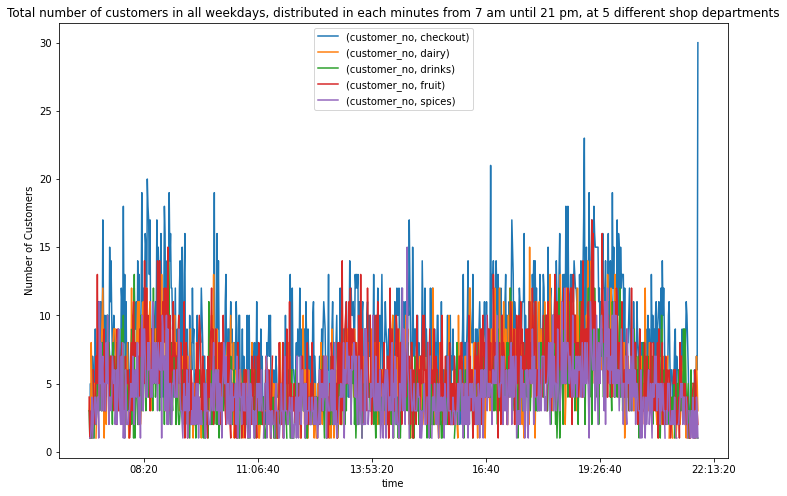

In [232]:
ax = df_unstack_location_time.plot(
    kind='line',
    title='Total number of customers in all weekdays, distributed in each minutes from 7 am until 21 pm, at 5 different shop departments',
    ylabel="Number of Customers",
    figsize=(12, 8)) 
    # subplots=True, 
#plt.tight_layout()
plt.legend(loc = "upper center")

In [233]:
df_location_hour = df.groupby(['location', 'hour'])[['customer_no']].count()
df_location_hour

customer_no
location hour             
checkout 7             454
         8             677
         9             455
         10            427
         11            342
...                    ...
spices   17            269
         18            346
         19            389
         20            246
         21            122

[75 rows x 1 columns]

In [234]:
df_unstack_location_hour = df_location_hour.unstack(level=0)
df_unstack_location_hour

customer_no                          
location    checkout dairy drinks fruit spices
hour                                          
7                454   275    278   299    238
8                677   455    348   468    342
9                455   291    231   336    207
10               427   294    198   270    242
11               342   210    150   244    165
12               384   225    188   247    208
13               514   340    238   389    273
14               496   319    229   345    261
15               412   233    190   316    184
16               518   337    272   353    262
17               556   360    294   410    269
18               630   425    361   453    346
19               755   466    441   507    389
20               492   298    307   312    246
21               333   151    180   173    122

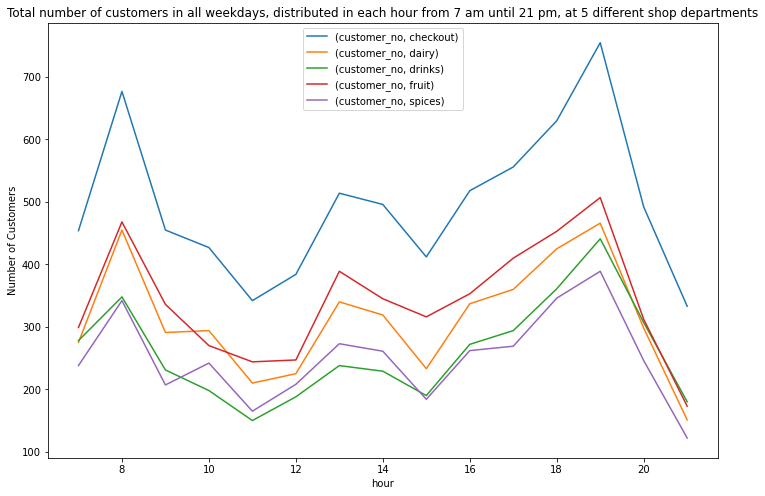

In [235]:
ax = df_unstack_location_hour.plot(
    kind='line',
    title='Total number of customers in all weekdays, distributed in each hour from 7 am until 21 pm, at 5 different shop departments',
    ylabel="Number of Customers",
    figsize=(12, 8)) 
    # subplots=True, 
#plt.tight_layout()
plt.legend(loc = "upper center")

### 4. 3. Display the number of customers at checkout over time

In [236]:
df_checkout = df.groupby(['location', 'hour', 'day'])[['customer_no']].count()
df_checkout

customer_no
location hour day             
checkout 7    0.0           92
              1.0           91
              2.0           85
              3.0           99
              4.0           87
...                        ...
spices   21   0.0           18
              1.0           27
              2.0           22
              3.0           35
              4.0           20

[375 rows x 1 columns]

In [237]:
# selecting the index day_of_week for unstacking: level=2
df_checkout = df_checkout.unstack()
df_checkout

customer_no                    
day                   0.0  1.0  2.0  3.0  4.0
location hour                                
checkout 7             92   91   85   99   87
         8            112  129  165  139  132
         9             85   77  106  105   82
         10            90   81   85   91   80
         11            55   47   88   73   79
...                   ...  ...  ...  ...  ...
spices   17            50   60   38   56   65
         18            70   58   46   74   98
         19            59   62  102  101   65
         20            52   52   35   53   54
         21            18   27   22   35   20

[75 rows x 5 columns]

In [238]:
df_checkout.loc['checkout']

customer_no                    
day          0.0  1.0  2.0  3.0  4.0
hour                                
7             92   91   85   99   87
8            112  129  165  139  132
9             85   77  106  105   82
10            90   81   85   91   80
11            55   47   88   73   79
12            73   60   89   72   90
13           120  104  102   80  108
14            90  110  105   83  108
15            94   72   79   86   81
16            86  118   94  118  102
17           122  109   98  112  115
18           128  134   97  123  148
19           129  127  192  172  135
20           109   99   85   96  103
21            62   64   61   86   60

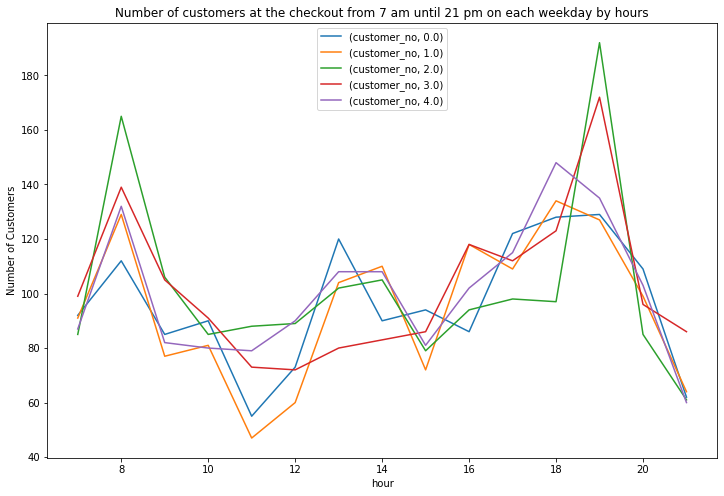

In [239]:
ax = df_checkout.loc['checkout'].plot(
    kind='line',
    title='Number of customers at the checkout from 7 am until 21 pm on each weekday by hours',
    ylabel="Number of Customers",
    figsize=(12, 8)) 
    # subplots=True, 
#plt.tight_layout()
plt.legend(loc = "upper center")

### 4.4. Calculate the time each customer spent in the market

In [240]:
df_timestamp = df.reset_index()

In [241]:
visits = df_timestamp.groupby(by=['day','customer_no'])['timestamp'].agg(['min', 'max'])
visits['duration'] = visits['max'] - visits['min']
visits.sort_values(by=['day', 'customer_no'], ascending=True)

min                 max        duration
day customer_no                                                        
0.0 0_1         2019-09-02 07:03:00 2019-09-02 07:05:00 0 days 00:02:00
    0_10        2019-09-02 07:06:00 2019-09-02 07:08:00 0 days 00:02:00
    0_100       2019-09-02 07:56:00 2019-09-02 08:03:00 0 days 00:07:00
    0_1000      2019-09-02 17:44:00 2019-09-02 17:51:00 0 days 00:07:00
    0_1001      2019-09-02 17:45:00 2019-09-02 17:46:00 0 days 00:01:00
...                             ...                 ...             ...
4.0 4_995       2019-09-06 17:17:00 2019-09-06 17:18:00 0 days 00:01:00
    4_996       2019-09-06 17:17:00 2019-09-06 17:23:00 0 days 00:06:00
    4_997       2019-09-06 17:18:00 2019-09-06 17:31:00 0 days 00:13:00
    4_998       2019-09-06 17:18:00 2019-09-06 17:23:00 0 days 00:05:00
    4_999       2019-09-06 17:18:00 2019-09-06 17:27:00 0 days 00:09:00

[7445 rows x 3 columns]

In [242]:
# another solution:
df_timestamp.groupby(['day', 'customer_no'])[['timestamp']].last() - df_timestamp.groupby(['day', 'customer_no'])[['timestamp']].first()

timestamp
day customer_no                
0.0 0_1         0 days 00:02:00
    0_10        0 days 00:02:00
    0_100       0 days 00:07:00
    0_1000      0 days 00:07:00
    0_1001      0 days 00:01:00
...                         ...
4.0 4_995       0 days 00:01:00
    4_996       0 days 00:06:00
    4_997       0 days 00:13:00
    4_998       0 days 00:05:00
    4_999       0 days 00:09:00

[7445 rows x 1 columns]

### 4.5. Calculate the total number of customers in the supermarket over time

In [243]:
df_customer_total = df.groupby(['day', 'hour'])[['customer_no']].count().unstack(level=0)
df_customer_total

customer_no                    
day          0.0  1.0  2.0  3.0  4.0
hour                                
7            317  328  279  315  305
8            364  463  547  447  469
9            308  262  373  323  254
10           282  267  283  303  296
11           189  133  287  227  275
12           265  199  271  234  283
13           412  330  358  297  357
14           305  343  344  299  359
15           342  223  246  266  258
16           307  405  310  384  336
17           410  366  305  392  416
18           449  444  319  455  548
19           404  437  674  590  453
20           377  320  290  333  335
21           163  196  169  242  189

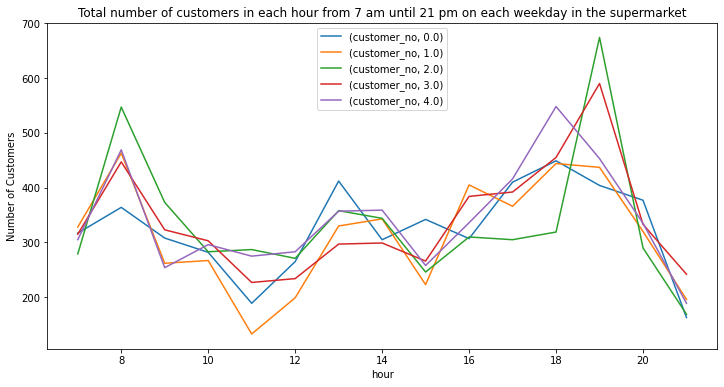

In [244]:
ax = df_customer_total.plot(
    kind='line',
    title='Total number of customers in each hour from 7 am until 21 pm on each weekday in the supermarket',
    ylabel="Number of Customers",
    figsize=(12, 6)) 
    # subplots=True, 
#plt.tight_layout()
plt.legend(loc = "upper center")

### 4.6. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

#### 4.6.1. Resampling data by customer_id and minutes

In [245]:
df.drop(['time', 'day', 'date', 'hour', 'minute'], 1, inplace=True)

/tmp/ipykernel_27230/4117425714.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(['time', 'day', 'date', 'hour', 'minute'], 1, inplace=True)


In [246]:
df

,customer_no,location
timestamp,,
2019-09-02 07:03:00,0_1,dairy
2019-09-02 07:03:00,0_2,dairy
2019-09-02 07:04:00,0_3,dairy
2019-09-02 07:04:00,0_4,dairy
2019-09-02 07:04:00,0_5,spices
...,...,...
2019-09-06 21:50:00,4_1508,checkout
2019-09-06 21:50:00,4_1509,drinks
2019-09-06 21:50:00,4_1509,checkout


In [247]:
# sort values by customer_no and timestamp 
df = df.sort_values(by=['customer_no', 'timestamp'])
df.head(10)

,customer_no,location
timestamp,,
2019-09-02 07:03:00,0_1,dairy
2019-09-02 07:05:00,0_1,checkout
2019-09-02 07:06:00,0_10,fruit
2019-09-02 07:08:00,0_10,checkout
2019-09-02 07:56:00,0_100,drinks
2019-09-02 08:03:00,0_100,checkout
2019-09-02 17:44:00,0_1000,dairy
2019-09-02 17:50:00,0_1000,drinks
2019-09-02 17:51:00,0_1000,checkout


In [248]:
# resempling by minutes, rule='T' means by Minute, 
# filling NaN cells with ffill method, which copies everything from above cells
df = df.groupby('customer_no').resample(rule='T').last().fillna(method='ffill')
df.head(10)

customer_no  location
customer_no timestamp                                
0_1         2019-09-02 07:03:00         0_1     dairy
            2019-09-02 07:04:00         0_1     dairy
            2019-09-02 07:05:00         0_1  checkout
0_10        2019-09-02 07:06:00        0_10     fruit
            2019-09-02 07:07:00        0_10     fruit
            2019-09-02 07:08:00        0_10  checkout
0_100       2019-09-02 07:56:00       0_100    drinks
            2019-09-02 07:57:00       0_100    drinks
            2019-09-02 07:58:00       0_100    drinks
            2019-09-02 07:59:00       0_100    drinks

#### 4.6.2. Creating Before-After Location Columns

In [249]:
# creating before column
df = df.rename(columns={"location": "before"})
df['after'] = df['before']

In [250]:
df

customer_no    before     after
customer_no timestamp                                          
0_1         2019-09-02 07:03:00         0_1     dairy     dairy
            2019-09-02 07:04:00         0_1     dairy     dairy
            2019-09-02 07:05:00         0_1  checkout  checkout
0_10        2019-09-02 07:06:00        0_10     fruit     fruit
            2019-09-02 07:07:00        0_10     fruit     fruit
...                                     ...       ...       ...
4_999       2019-09-06 17:23:00       4_999     fruit     fruit
            2019-09-06 17:24:00       4_999    drinks    drinks
            2019-09-06 17:25:00       4_999     fruit     fruit
            2019-09-06 17:26:00       4_999     fruit     fruit
            2019-09-06 17:27:00       4_999  checkout  checkout

[53940 rows x 3 columns]

### 4.6.3. Creating "entrance" value in Before column

In [251]:
# shifting before column with one row down 
df['before'] = df['before'].shift(1)
df.head(5)

customer_no    before     after
customer_no timestamp                                          
0_1         2019-09-02 07:03:00         0_1       NaN     dairy
            2019-09-02 07:04:00         0_1     dairy     dairy
            2019-09-02 07:05:00         0_1     dairy  checkout
0_10        2019-09-02 07:06:00        0_10  checkout     fruit
            2019-09-02 07:07:00        0_10     fruit     fruit

In [252]:
# replacing 'checkout' and NaN values in the before column  
df["before"].replace({"checkout": "entrance"}, inplace=True)
df["before"].fillna('entrance', inplace=True)

In [253]:
df.head(10)

customer_no    before     after
customer_no timestamp                                          
0_1         2019-09-02 07:03:00         0_1  entrance     dairy
            2019-09-02 07:04:00         0_1     dairy     dairy
            2019-09-02 07:05:00         0_1     dairy  checkout
0_10        2019-09-02 07:06:00        0_10  entrance     fruit
            2019-09-02 07:07:00        0_10     fruit     fruit
            2019-09-02 07:08:00        0_10     fruit  checkout
0_100       2019-09-02 07:56:00       0_100  entrance    drinks
            2019-09-02 07:57:00       0_100    drinks    drinks
            2019-09-02 07:58:00       0_100    drinks    drinks
            2019-09-02 07:59:00       0_100    drinks    drinks

In [254]:
# transition matrix with crosstabs, normalize=0 calculates probabilities for each row 
matrix = pd.crosstab(df['before'], df['after'], normalize=0)
matrix

after,checkout,dairy,drinks,fruit,spices
before,,,,,
dairy,0.103313,0.737023,0.058546,0.049772,0.051347
drinks,0.215630,0.010900,0.598560,0.087918,0.086992
entrance,0.000537,0.287441,0.153392,0.377300,0.181330
fruit,0.201558,0.095744,0.054834,0.597199,0.050665
spices,0.150526,0.193214,0.163109,0.090953,0.402198


In [255]:
def plot_probabilities(matrix):

    locations = ['dairy', 'drinks', 'entrance',  'fruit', 'spices']

    for location in locations: 
        df = pd.DataFrame(matrix.loc[f'{location}']).plot(kind='bar')
    return df    


<AxesSubplot:xlabel='after'>

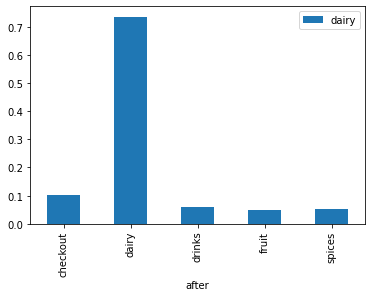

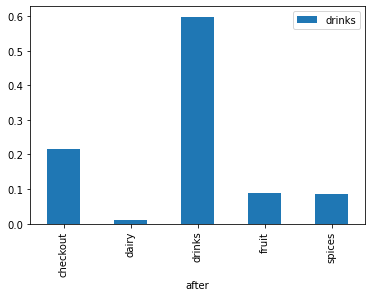

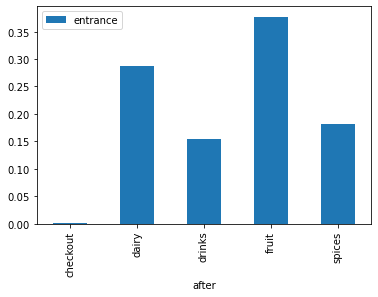

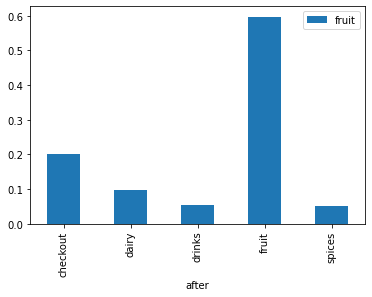

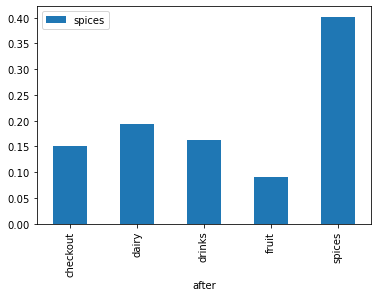

In [256]:
plot_probabilities(matrix)